In [0]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
% matplotlib inline

In [0]:
def get_market_data(market, tag=True):
  """
  market: The full name of the cryptocurrency as spelled on coinmarketcap.com
  tag: Add tag eg: btc to all columns of the data
  returns pandas data frame
  """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                            "/historical-data/?start=20160428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data

In [44]:
btc_data = get_market_data("bitcoin", tag="BTC")
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market Cap
0,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000
1,2018-03-28,7836.83,8122.89,7809.17,7954.48,4935290000,132781000000
2,2018-03-27,8200.00,8232.78,7797.28,7833.04,5378250000,138919000000
3,2018-03-26,8498.47,8530.08,7921.43,8209.40,5921040000,143960000000
4,2018-03-25,8612.81,8682.01,8449.10,8495.78,4569880000,145882000000


In [0]:
merge_date = '2016-01-01' # Default merging date if date is not mentioned
def merge_data(a, b, from_date=merge_date):
  """
  a: First data frame
  b: Second data frame
  from_date: Drop all data before this date
  returns merged pandas data frame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data

In [0]:
def add_volatility(data, coins=['BTC', 'ETH']):
  """
  data: input data, pandas dataframe
  coins: default is for btc and eth can be changed
  This function calculates the volatility and close off high of each given coin
  each day and adds the result as new columns to the data frame
  returns data frame with added columns
  """
  for coin in coins:
    # Calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + 'close_off_high': lambda x: 2 * (x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + 'volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
    return data

In [0]:
def create_model_data(data):
  """
  data: pandas data frame
  drop unnecessary columns and revrse in descending order
  return the pandas dataframe
  """
  data = data[['Date'] + [coin + metric for coin in ['BTC_', 'ETH_'] for metric in ['Close', 'Volume']]]
  data = data.sort_values(by='Date')
  return data

In [0]:
def split_data(data, training_size = 0.8):
  # Returns train and test data set
  return data[:int(training_size * len(data))], data[int(training_size * len(data)):]

In [0]:
window_len = 30
def create_inputs(data, coins=['BTC', 'ETH'], window_length=window_len):
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_length):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

In [0]:
def create_outputs(data, coin, window_length=window_len):
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1

In [0]:
def to_array(data):
  x = [np.array(data[i]) for i in range(len(data))]
  return np.array(x)

In [0]:
neurons = 1024
activation_function = 'tanh'
loss = 'mse'
optimizer='adam'
dropout = 0.25
batch_size = 128
epochs = 53
def build_model(inputs, output_size, neurons, activ_fun=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  model.add(LSTM(neurons, return_sequences = True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_fun))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_fun))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [0]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(x_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(x_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(x_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [65]:
btc_data = get_market_data('bitcoin', tag='BTC')
etc_data = get_market_data('ethereum', tag='ETH')
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market Cap
0,2018-03-29,7979.07,7994.33,7081.38,7165.70,6361230000,135205000000
1,2018-03-28,7836.83,8122.89,7809.17,7954.48,4935290000,132781000000
2,2018-03-27,8200.00,8232.78,7797.28,7833.04,5378250000,138919000000
3,2018-03-26,8498.47,8530.08,7921.43,8209.40,5921040000,143960000000
4,2018-03-25,8612.81,8682.01,8449.10,8495.78,4569880000,145882000000


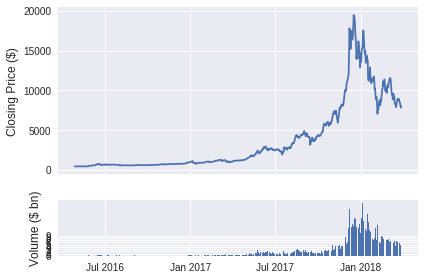

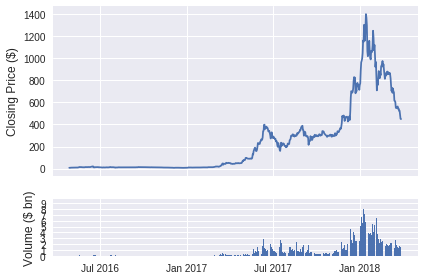

In [66]:
show_plot(btc_data, tag='BTC')
show_plot(etc_data, tag='ETH')

In [67]:
market_data = merge_data(btc_data, etc_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)
model_data.head()

,Date,BTC_Close,BTC_Volume,ETH_Close,ETH_Volume
700,2016-04-28,449.01,74064700,7.17,11576000
699,2016-04-29,455.10,49258500,7.46,8762080
698,2016-04-30,448.32,69322600,8.81,36573300
697,2016-05-01,451.88,40660100,8.85,16713800
696,2016-05-02,444.67,92127000,10.16,41019200


In [0]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

x_train = create_inputs(train_set)
y_train_btc = create_outputs(train_set, coin='BTC')
x_test = create_inputs(test_set)
y_test_btc = create_outputs(test_set, coin='BTC')
y_train_eth = create_outputs(train_set, coin='ETH')
y_test_eth = create_outputs(test_set, coin='ETH')
x_train, x_test = to_array(x_train), to_array(x_test)


In [69]:
gc.collect()
np.random.seed(202)
btc_model = build_model(x_train, output_size=1, neurons=neurons)
btc_history = btc_model.fit(x_train, y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 1024)          4214784   
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 1024)          8392704   
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 1024)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 1024)          8392704   
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 1024)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1024)              8392704   
__________

Epoch 8/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0242 - mean_absolute_error: 0.1083 - val_loss: 0.0773 - val_mean_absolute_error: 0.1883
Epoch 9/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0193 - mean_absolute_error: 0.0997 - val_loss: 0.0570 - val_mean_absolute_error: 0.1484
Epoch 10/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0244 - mean_absolute_error: 0.1085 - val_loss: 0.0799 - val_mean_absolute_error: 0.2097
Epoch 11/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0221 - mean_absolute_error: 0.1110 - val_loss: 0.0588 - val_mean_absolute_error: 0.1775
Epoch 12/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0818 - val_loss: 0.0508 - val_mean_absolute_error: 0.1449
Epoch 13/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0124 - mean_absolute_error: 0.0782 - val_loss: 0.0494 - val_mean_absolute_error: 0.1520
Epoch 14/53


Epoch 22/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0665 - val_loss: 0.0482 - val_mean_absolute_error: 0.1371
Epoch 23/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0062 - mean_absolute_error: 0.0532 - val_loss: 0.0423 - val_mean_absolute_error: 0.1320
Epoch 24/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0066 - mean_absolute_error: 0.0563 - val_loss: 0.0419 - val_mean_absolute_error: 0.1245
Epoch 25/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0066 - mean_absolute_error: 0.0554 - val_loss: 0.0406 - val_mean_absolute_error: 0.1258
Epoch 26/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0598 - val_loss: 0.0399 - val_mean_absolute_error: 0.1208
Epoch 27/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0088 - mean_absolute_error: 0.0621 - val_loss: 0.0396 - val_mean_absolute_error: 0.1253
Epoch 28/5

Epoch 36/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0092 - mean_absolute_error: 0.0673 - val_loss: 0.0372 - val_mean_absolute_error: 0.1147
Epoch 37/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0080 - mean_absolute_error: 0.0605 - val_loss: 0.0415 - val_mean_absolute_error: 0.1275
Epoch 38/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0508 - val_loss: 0.0380 - val_mean_absolute_error: 0.1168
Epoch 39/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0515 - val_loss: 0.0407 - val_mean_absolute_error: 0.1245
Epoch 40/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0464 - val_loss: 0.0367 - val_mean_absolute_error: 0.1121
Epoch 41/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0461 - val_loss: 0.0378 - val_mean_absolute_error: 0.1177
Epoch 42/5

Epoch 50/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0063 - mean_absolute_error: 0.0549 - val_loss: 0.0361 - val_mean_absolute_error: 0.1102
Epoch 51/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0073 - mean_absolute_error: 0.0587 - val_loss: 0.0456 - val_mean_absolute_error: 0.1422
Epoch 52/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0054 - mean_absolute_error: 0.0524 - val_loss: 0.0360 - val_mean_absolute_error: 0.1100
Epoch 53/53
530/530 [==============================] - 4s 7ms/step - loss: 0.0054 - mean_absolute_error: 0.0519 - val_loss: 0.0381 - val_mean_absolute_error: 0.1157


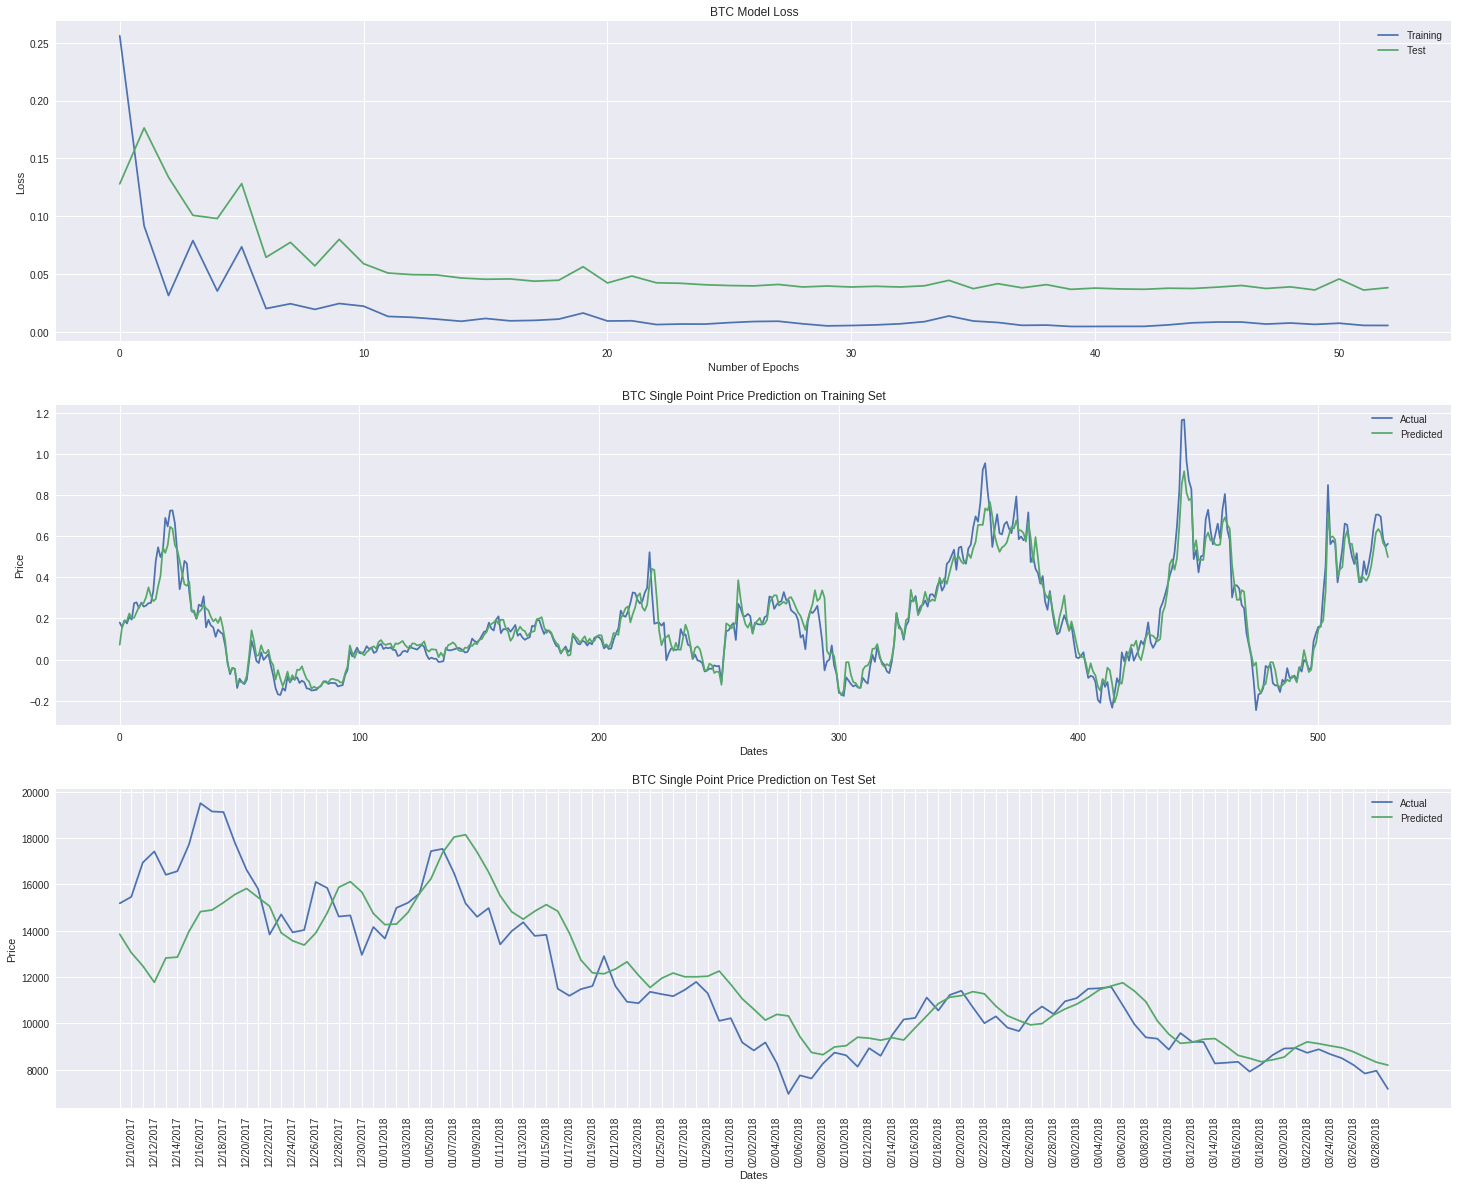

In [70]:
plot_results(btc_history, btc_model, y_train_btc, coin='BTC')